In [1]:
import warnings
from typing import Any
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

from utils import plot_roc
import ml_utils as utils
from ml_utils import get_weights_for_roc_auc, weighted_roc_metric, get_optimal_trs, plot_roc, plot_roc_curves
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# aft, magn > 6

## read 

In [2]:
dataset_type_train = "magn_6_aft"
dataset_type_test = "magn_6_aft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [3]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_aft.parquet
test_path: data/dataset/magn_6_aft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-21

train: target==0: 2326760, target==1: 200
test: target==0: 9366239, target==1: 761
target class proportion: test: 8.124926130968898e-05, train: 8.595643727758772e-05


In [4]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [5]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [6]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [7]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [8]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [9]:
roc_auc_weights_test

array([0.00721154, 0.00721154, 0.00721154, ..., 0.00240385, 0.00240385,
       0.00240385])

In [10]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(9367000,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

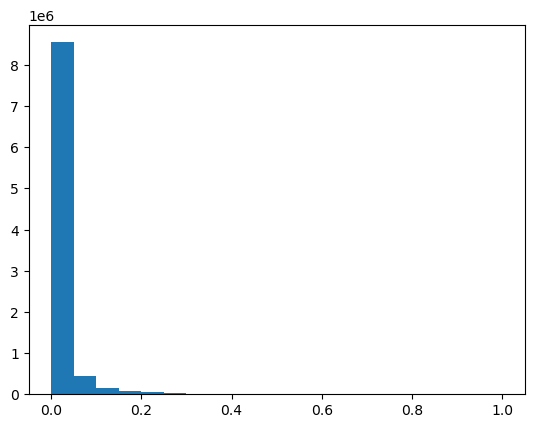

In [11]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [12]:
y_train = y_train[target]
y_test = y_test[target]

In [13]:
y_train.sum(), y_test.sum()

(200, 761)

## lgbm

In [14]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [15]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-20, 2015-10-31], len: 591600 | test: [2015-11-10, 2017-06-22], len: 591600
train: [2014-03-20, 2017-06-22], len: 1183200 | test: [2017-07-02, 2019-02-22], len: 601460
train: [2014-03-20, 2019-02-22], len: 1784660 | test: [2019-03-04, 2020-08-25], len: 542300


### baseline

In [18]:
params = {
    "n_estimators": 5,
    "objective": "binary",
    "use_missing": False,
    "deterministic": True,
    "random_state": 42,
    "force_col_wise": True,
    "feature_pre_filter": False,
    "verbosity": -1,
    "max_depth": 2,
    "n_jobs": 50,
    "reg_lambda": 10.0,
}

lgbm_model = train.get_lgbm_model(feature_cols, params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.8292120255204661, 0.7157388482530992)

### shap feature selection

In [17]:
from sklearn.metrics import make_scorer
from probatus.utils import Scorer


weighted_roc_auc_sklearn_scorer = make_scorer(weighted_roc_metric, greater_is_better=True)
weighted_roc_auc_probatus_scorer = Scorer("weighted_roc_auc", custom_scorer=weighted_roc_auc_sklearn_scorer)

shap_params = params.copy()
shap_params["n_jobs"] = 5

lgbm_reg = lgb.LGBMRegressor(**shap_params)

imputer = SimpleImputer(
    strategy="constant",
    fill_value=0.0,
).set_output(transform="pandas")
X_train_preprocessed = imputer.fit_transform(X_train)

shap_elimination, lgbm_shap_features = train.select_features(
    model=lgbm_reg,
    X=X_train_preprocessed,
    y=y_train,
    cv=cv,
    n_jobs=20,
    metric=weighted_roc_auc_probatus_scorer,
    step=0.05,
    return_rfe=True,
)

 96%|=================== | 519403/542300 [00:20<00:00]       2025-03-03 21:31:20.241 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 372, Current performance: Train 0.5255526173817024 +/- 0.09050623423125427, CV Validation 0.48665542139709633 +/- 0.022553688593026876. 
Features left: ['std_magn_90_rad0', 'mean_magn_m6.0_180_rad0', 'count_earthquakes_365_rad0', 'max_magn_m4.0_1095_rad3', 'max_magn_m4.0_90_rad5', 'std_magn_2555_rad3', 'count_earthquakes_m6.0_1825_rad0', 'mean_magn_3650_rad0', 'std_magn_3650_rad3', 'min_magn_m4.0_3650_rad0', 'mean_magn_m6.0_1825_rad0', 'std_magn_90_rad5', 'min_magn_90_rad0', 'max_magn_m4.0_180_rad3', 'cell_x', 'std_magn_2555_rad5', 'count_earthquakes_m4.0_180_rad5', 'min_magn_m4.0_1825_rad3', 'min_magn_m6.0_365_rad3', 'mean_magn_m4.0_2555_rad3', 'max_magn_m6.0_180_rad0', 'mean_magn_2555_rad3', 'mean_magn_m4.0_1095_rad5', 'mean_magn_180_rad5', 'max_magn_m4.0_2555_rad0', 'max_magn_m4.0_365_rad3',

In [18]:
lgbm_shap_features

['mean_magn_m4.0_1095_rad5',
 'mean_magn_m4.0_90_rad5',
 'min_magn_m4.0_1095_rad0',
 'min_magn_m4.0_60_rad0',
 'day_of_year',
 'count_earthquakes_m4.0_90_rad5',
 'std_magn_m6.0_2555_rad3',
 'count_earthquakes_m4.0_3650_rad0',
 'mean_magn_m4.0_180_rad5',
 'std_magn_m4.0_2555_rad3',
 'std_magn_m6.0_3650_rad3',
 'min_magn_m4.0_90_rad5',
 'mean_magn_m4.0_60_rad5']

In [19]:
print(len(lgbm_shap_features))

13


In [19]:
lgbm_shap_features = [
    'mean_magn_m4.0_1095_rad5',
    'mean_magn_m4.0_90_rad5',
    'min_magn_m4.0_1095_rad0',
    'min_magn_m4.0_60_rad0',
    'day_of_year',
    'count_earthquakes_m4.0_90_rad5',
    'std_magn_m6.0_2555_rad3',
    'count_earthquakes_m4.0_3650_rad0',
    'mean_magn_m4.0_180_rad5',
    'std_magn_m4.0_2555_rad3',
    'std_magn_m6.0_3650_rad3',
    'min_magn_m4.0_90_rad5',
    'mean_magn_m4.0_60_rad5'
]

In [20]:
shap_params = params.copy()
shap_params["n_jobs"] = 5
lgbm_model = train.get_lgbm_model(lgbm_shap_features, shap_params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7895667666626554, 0.723982354159551)

### hyper optimiziation

In [21]:
import optuna
import optuna.trial
import optuna.logging

optuna.logging.set_verbosity(optuna.logging.WARNING)


def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "objective": "binary",
        "use_missing": False,
        "deterministic": True,
        "random_state": 42,
        "force_col_wise": True,
        "feature_pre_filter": False,
        "verbosity": -1,
        "n_jobs": 1,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "colsample_bytree": 1.0,
        "subsample": 1.0,
        "learning_rate": 0.01,
        "num_leaves": 31,
        "min_child_samples": 20,
        "n_estimators": 10,
        "max_depth": 2,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "n_estimators": trial.suggest_int("n_estimators", 3, 10, step=1),
        "max_depth": trial.suggest_int("max_depth", 1, 2, step=1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001),
        "num_leaves": trial.suggest_int("num_leaves", 5, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 29.6, step=0.5),
    }
    params.update(kwargs)

    return params

tuned_lgbm = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 500,
    dump_study_path = f"data/optuna_res/lgbm_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_lgbm_model(lgbm_shap_features, default_params()),
    n_jobs = 50,
    model_name = "lgbmclassifier",
)

using MonthlyTimeSeriesSplit


lgbmclassifier hyperoptimisation:  87%|████████▋ | 437/500 [1:59:10<37:43, 35.92s/it]  /home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
lgbmclassifier hyperoptimisation: 100%|██████████| 500/500 [2:40:31<00:00, 19.26s/it]


In [23]:
tuned_lgbm_params = tuned_lgbm["lgbmclassifier"].get_params()
tuned_lgbm_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.10003059915564513,
 'importance_type': 'split',
 'learning_rate': 0.093,
 'max_depth': 2,
 'min_child_samples': 12,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 5,
 'n_jobs': 1,
 'num_leaves': 25,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 13.1,
 'silent': 'warn',
 'subsample': 0.7647390817540256,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'use_missing': False,
 'deterministic': True,
 'force_col_wise': True,
 'feature_pre_filter': False,
 'verbosity': -1}

In [21]:
tuned_params = {'boosting_type': 'gbdt',
'class_weight': None,
'colsample_bytree': 0.10003059915564513,
'importance_type': 'split',
'learning_rate': 0.093,
'max_depth': 2,
'min_child_samples': 12,
'min_child_weight': 0.001,
'min_split_gain': 0.0,
'n_estimators': 5,
'n_jobs': 1,
'num_leaves': 25,
'objective': 'binary',
'random_state': 42,
'reg_alpha': 0.0,
'reg_lambda': 13.1,
'silent': 'warn',
'subsample': 0.7647390817540256,
'subsample_for_bin': 200000,
'subsample_freq': 0,
'use_missing': False,
'deterministic': True,
'force_col_wise': True,
'feature_pre_filter': False,
'verbosity': -1}
tuned_lgbm = train.get_lgbm_model(features=lgbm_shap_features, params=tuned_params)

In [22]:
reulst_aft_lgbm = tuned_lgbm.fit(X_train, y_train)
y_pred_prob = reulst_aft_lgbm.predict_proba(X_test)

(
    roc_auc_score(y_train, reulst_aft_lgbm.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.7211818773745465, 0.7756972903294259)

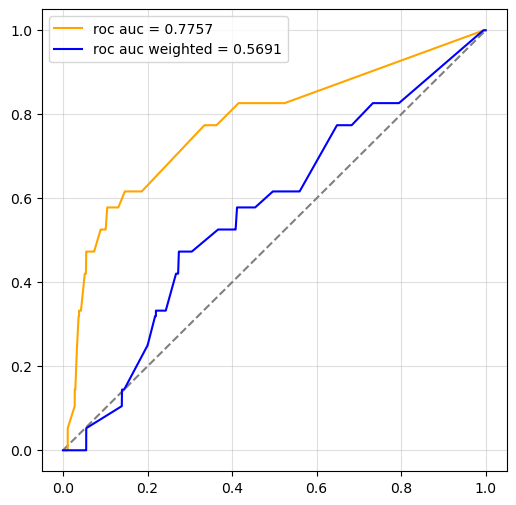

In [76]:
from ml_utils import plot_roc_curves

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=int(1e10))

In [ ]:
with open("data/models/aft_6_lgbm.pickle", "xb") as f:
    joblib.dump(reulst_aft_lgbm, f)

# withoutaft, magn > 6

## read 

In [77]:
dataset_type_train = "magn_6_withoutaft"
dataset_type_test = "magn_6_withoutaft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [78]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_withoutaft.parquet
test_path: data/dataset/magn_6_withoutaft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-09

train: target==0: 1878932, target==1: 100
test: target==0: 95163, target==1: 513
target class proportion: test: 0.005390750606853504, train: 5.3221723830346177e-05


In [79]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [80]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [81]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [82]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [83]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [84]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(95676,
 0.6418269230769231,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04326923, 0.04567308, 0.04807692, 0.05048077,
        0.05288462, 0.05528846, 0.06490385, 0.06730769, 0.06971154,
        0.07211538, 0.07451923, 0.07932692, 0.08413462, 0.09134615,
        0.09615385, 0.09855769, 0.10096154, 0.10576923, 0.10817308,
        0.11298077, 0.11538462, 0.11778846, 0.13701923, 0.14423077,
        0.17067308, 0.20192308, 0.20673077, 0.20913462, 0.21394231,
        0.24278846, 0.27644231, 0.30048077, 0.33894231, 0.35336538,
        0.37019231, 0.37259615, 0.41105769, 0.64182692]))

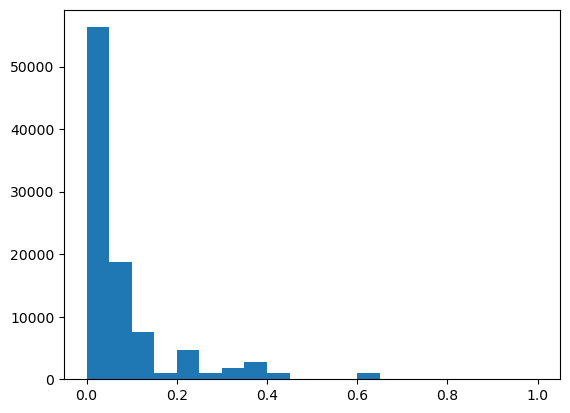

In [85]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [86]:
y_train = y_train[target]
y_test = y_test[target]

In [87]:
y_train.sum(), y_test.sum()

(100, 513)

## lgbm

In [88]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [89]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-20, 2015-10-31], len: 477720 | test: [2015-11-10, 2017-06-22], len: 477720
train: [2014-03-20, 2017-06-22], len: 955440 | test: [2017-07-02, 2019-02-22], len: 485682
train: [2014-03-20, 2019-02-22], len: 1441122 | test: [2019-03-04, 2020-08-25], len: 437910


### baseline

In [107]:
params = {
    "n_estimators": 5,
    "objective": "binary",
    "use_missing": False,
    "deterministic": True,
    "random_state": 42,
    "force_col_wise": True,
    "feature_pre_filter": False,
    "verbosity": -1,
    "max_depth": 2,
    "learning_rate": 0.01,
    "n_jobs": 45,
    "reg_lambda": 100.0,
}

lgbm_model = train.get_lgbm_model(feature_cols, params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.828312871354578, 0.5924259860771564)

### shap feature selection

In [108]:
shap_params = params.copy()
shap_params["n_jobs"] = 5

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lgbm_reg = lgb.LGBMRegressor(**shap_params)

imputer = SimpleImputer(
    strategy="constant",
    fill_value=0.0,
).set_output(transform="pandas")
X_train_preprocessed = imputer.fit_transform(X_train)

shap_elimination, lgbm_shap_features = train.select_features(
    model=lgbm_reg,
    X=X_train_preprocessed,
    y=y_train,
    cv=cv,
    n_jobs=20,
    metric="roc_auc",
    step=0.05,
    return_rfe=True,
)

 96%|=================== | 420637/437910 [00:19<00:00]       2025-03-04 18:29:46.493 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 372, Current performance: Train 0.8439952280086604 +/- 0.08668857734709234, CV Validation 0.5357949126122042 +/- 0.09227816319633529. 
Features left: ['std_magn_90_rad0', 'mean_magn_m6.0_180_rad0', 'count_earthquakes_365_rad0', 'max_magn_m4.0_1095_rad3', 'max_magn_m4.0_90_rad5', 'std_magn_2555_rad3', 'count_earthquakes_m6.0_1825_rad0', 'mean_magn_3650_rad0', 'std_magn_3650_rad3', 'min_magn_m4.0_3650_rad0', 'mean_magn_m6.0_1825_rad0', 'std_magn_90_rad5', 'min_magn_90_rad0', 'max_magn_m4.0_180_rad3', 'cell_x', 'count_earthquakes_m4.0_180_rad5', 'std_magn_2555_rad5', 'min_magn_m4.0_1825_rad3', 'min_magn_m6.0_365_rad3', 'mean_magn_m4.0_2555_rad3', 'max_magn_m6.0_180_rad0', 'mean_magn_2555_rad3', 'mean_magn_m4.0_1095_rad5', 'mean_magn_180_rad5', 'max_magn_m4.0_2555_rad0', 'max_magn_m4.0_365_rad3', '

In [109]:
lgbm_shap_features

['day_of_year',
 'count_earthquakes_m4.0_2555_rad3',
 'count_earthquakes_m4.0_2555_rad5',
 'max_magn_m4.0_3650_rad5',
 'std_magn_m4.0_3650_rad5',
 'std_magn_m4.0_2555_rad3',
 'min_magn_m4.0_1095_rad3',
 'min_magn_m4.0_3650_rad5',
 'min_magn_m4.0_1825_rad5',
 'std_magn_m4.0_365_rad3']

In [110]:
len(lgbm_shap_features)

10

In [111]:
lgbm_model = train.get_lgbm_model(lgbm_shap_features, shap_params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7538549878335139, 0.4911656042543932)

In [140]:
params = {
    "n_estimators": 5,
    "objective": "binary",
    "use_missing": False,
    "deterministic": True,
    "random_state": 42,
    "force_col_wise": True,
    "feature_pre_filter": False,
    "verbosity": -1,
    "max_depth": 2,
    "learning_rate": 1.9,
    "n_jobs": 45,
    "reg_lambda": 20,
}

lgbm_model = train.get_lgbm_model(lgbm_shap_features, params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.8738195767595633, 0.6119978629465123)

### hyper optimiziation

In [142]:
import optuna
import optuna.trial
import optuna.logging

optuna.logging.set_verbosity(optuna.logging.WARNING)


def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "objective": "binary",
        "use_missing": False,
        "deterministic": True,
        "random_state": 42,
        "force_col_wise": True,
        "feature_pre_filter": False,
        "verbosity": -1,
        "n_jobs": 1,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "colsample_bytree": 1.0,
        "subsample": 1.0,
        "learning_rate": 1.9,
        "num_leaves": 31,
        "min_child_samples": 20,
        "n_estimators": 10,
        "max_depth": 2,
        "reg_lambda": 20.0,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "n_estimators": trial.suggest_int("n_estimators", 3, 10, step=1),
        "max_depth": trial.suggest_int("max_depth", 1, 2, step=1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 3.0, step=0.001),
        "num_leaves": trial.suggest_int("num_leaves", 5, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 5.0, 30.0, step=0.5),
    }
    params.update(kwargs)

    return params

tuned_lgbm = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 500,
    dump_study_path = f"data/optuna_res/lgbm_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_lgbm_model(lgbm_shap_features, default_params()),
    n_jobs = 50,
    model_name = "lgbmclassifier",
)

using MonthlyTimeSeriesSplit


lgbmclassifier hyperoptimisation: 100%|██████████| 500/500 [1:39:58<00:00, 12.00s/it]


In [143]:
tuned_lgbm_params = tuned_lgbm["lgbmclassifier"].get_params()
tuned_lgbm_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5476626553957408,
 'importance_type': 'split',
 'learning_rate': 2.794,
 'max_depth': 1,
 'min_child_samples': 40,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 4,
 'n_jobs': 1,
 'num_leaves': 43,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 5.5,
 'silent': 'warn',
 'subsample': 0.8095842830893356,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'use_missing': False,
 'deterministic': True,
 'force_col_wise': True,
 'feature_pre_filter': False,
 'verbosity': -1}

In [144]:
reulst_witoutaft_lgbm = tuned_lgbm.fit(X_train, y_train)
y_pred_prob = reulst_witoutaft_lgbm.predict_proba(X_test)

(
    roc_auc_score(y_train, reulst_witoutaft_lgbm.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.7296645913742488, 0.6389264309176792)

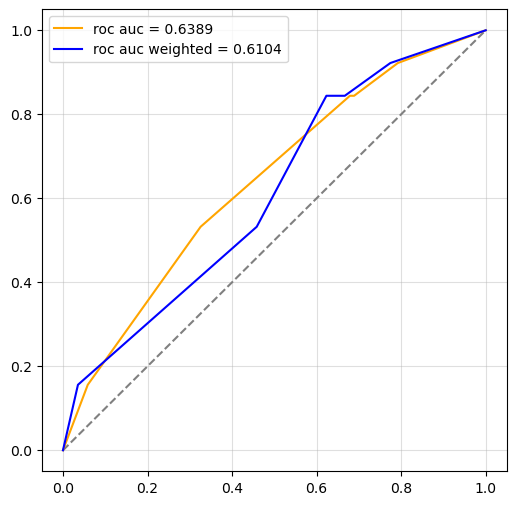

In [146]:
plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=int(1e10))

In [ ]:
with open("data/models/witoutaft_6_lgbm.pickle", "xb") as f:
    joblib.dump(reulst_witoutaft_lgbm, f)